In [8]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from datetime import datetime, timedelta

In [9]:
# read all data in that has the patter of "SIF_*.nc"
directory = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/retrieval_from_realData/20250927/"
file_pattern = "SIF_*.nc"
# grep the files in the directory that match the pattern
file_paths = glob.glob(directory + file_pattern)
# read all the files into a list of xarray datasets
datasets = [xr.open_dataset(file_path) for file_path in file_paths]


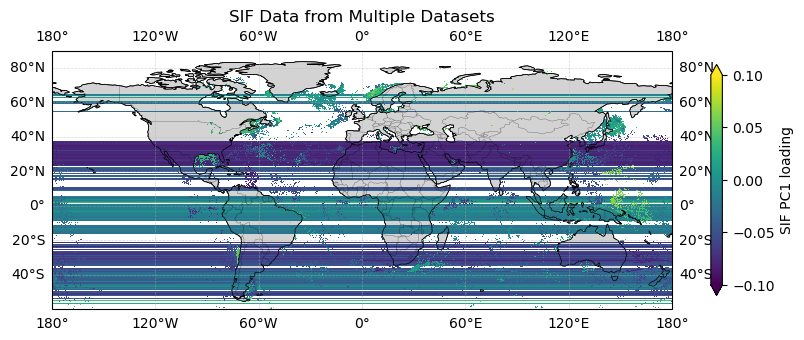

In [10]:
# visualize them on a map altogether at the same time
def visualize_sif_on_map(datasets):
    # create a figure and axis with cartopy projection
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

    # Set global extent
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # loop through each dataset and plot the SIF data
    for ds in datasets:
        # extract the SIF data and coordinates
        sif = ds["retrieved_state_vector"].isel(state_vector=-2).values 
        lat = ds["latitude"].values
        lon = ds["longitude"].values
        # pcolormesh
        sc = ax.pcolormesh(lon, lat, sif, transform=ccrs.PlateCarree(), cmap='viridis', shading='auto')
    # add a colorbar
    plt.colorbar(sc, ax=ax, label="SIF PC1 loading", orientation='vertical', 
                    pad=0.05, shrink=0.5, extend='both')
    # set title and labels
    ax.set_title('SIF Data from Multiple Datasets')
    plt.show()

visualize_sif_on_map(datasets[:])


In [38]:
# Define the global grid
lon_bins = np.arange(-180, 180 + 0.1, 0.1)
lat_bins = np.arange(-90, 90 + 0.1, 0.1)
global_hist = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
global_count = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# Print the shape
print(f"Global map shape: {global_hist.shape}, Longitude bins: {len(lon_bins)-1}, Latitude bins: {len(lat_bins)-1}")

# Loop through each dataset
for ds in datasets:
    # Extract SIF data and coordinates
    sif = ds["retrieved_state_vector"].isel(state_vector=-2).values
    lat = ds["latitude"].values
    lon = ds["longitude"].values

    # Map SIF data to the global grid
    hist, _, _ = np.histogram2d(lat.flatten(), lon.flatten(), bins=[lat_bins, lon_bins], weights=sif.flatten())
    count, _, _ = np.histogram2d(lat.flatten(), lon.flatten(), bins=[lat_bins, lon_bins])
    # add the histogram to the global histogram
    global_hist += hist
    global_count += count

# Calculate the average SIF value for each grid cell
global_map = np.divide(global_hist, global_count, out=np.zeros_like(global_hist), where=global_count!=0)

Global map shape: (1800, 3600), Longitude bins: 3600, Latitude bins: 1800


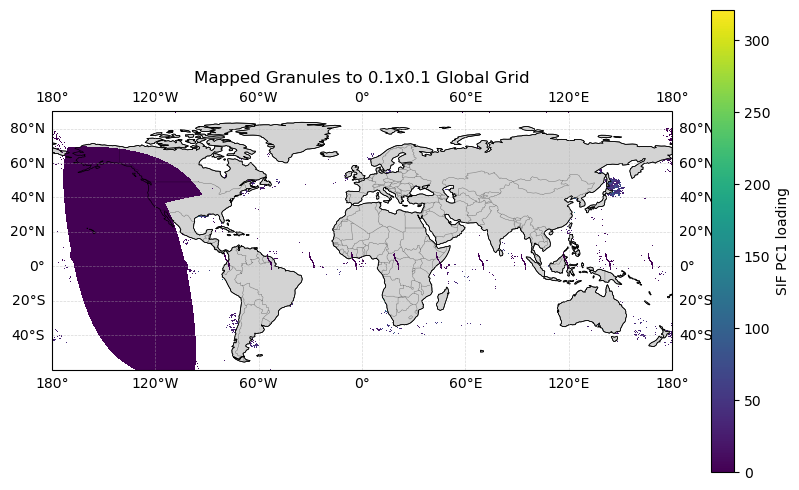

In [40]:
# Visualize the global map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

# Set global extent
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

pcm = ax.pcolormesh(lon_bins[:-1], lat_bins[:-1], global_hist, cmap='viridis', shading='auto')
plt.colorbar(pcm, ax=ax, label="SIF PC1 loading")
plt.title("Mapped Granules to 0.1x0.1 Global Grid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()